# Digit Classification using neural networks 

In [346]:
import os
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix

from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

Reading the data


In [347]:
def load_data( data_path ):
    '''
    Loads the data from the specified path.
    
    Inputs:
    data_path: path to the directory containing the data files, each file containing measurement of a digit
    in a N x 3 matrix. 
    
    Returns:
    data: a list of numpy arrays, each array containing the measurement of a digit.
    labels: a list of labels corresponding to the data.
    '''
    files = os.scandir( data_path )

    data_raw = []
    labels = []
    for file in files:
        filename = file.name
        if filename.endswith('.csv'):
            number_data = np.loadtxt(data_path + '/' + filename, delimiter=',', dtype=np.float32)
            label = int( filename.split('_')[1] )
            
            data_raw.append( number_data.transpose() )
            labels.append( label )      
                    
    return data_raw, np.array(labels)

data_path = os.getcwd() + '/data/digits_3d/training_data'
data_raw, labels = load_data( data_path )

Trying something new: summary statistics

In [348]:
def create_bins( bin_min, bin_max, N_bins = 15 ):
    delta = ( bin_max - bin_min ) / 1000
    bin_min += delta
    bin_max -= delta
    
    bins = np.linspace( bin_min, bin_max, N_bins )
         
    return bins

def empcdf(data, nx=100, x=None):

    ndata = len(data)
    cdf_emp = np.zeros( nx, dtype=np.float32 )

    for ii in range(nx):
        # print( x[ii] )
        # print( sum(data <= x[ii]) )
        # print(data)
        cdf_emp[ii] += np.sum( data <=  x[ii] )

    cdf_emp /= ndata
    
    return cdf_emp, x

In [349]:
def create_ecdf( data ):
    nbins = 10
    xmin, ymin, zmin = 10, 10, 10
    xmax, ymax, zmax = -10, -10, -10
    for number in data:
        xmin0, ymin0, zmin0 = np.min( number, axis=1 )
        xmax0, ymax0, zmax0 = np.max( number, axis=1 )
        
        if xmin0 < xmin:
            xmin = xmin0
        if ymin0 < ymin:
            ymin = ymin0
        if zmin0 < zmin:
            zmin = zmin0
            
        if xmax0 > xmax:
            xmax = xmax0
        if ymax0 > ymax:
            ymax = ymax0
        if zmax0 > zmax:
            zmax = zmax0
            
    x_bins = create_bins( xmin, xmax, N_bins=nbins)
    y_bins = create_bins( ymin, ymax, N_bins=nbins )
    z_bins = create_bins( zmin, zmax, N_bins=nbins )

    data_processed = []
    for ii, number in enumerate( data ):
        temp_x = empcdf( number[ 0, : ], nx=nbins, x=x_bins )
        temp_y = empcdf( number[ 1, : ], nx=nbins, x=y_bins )
        temp_z = empcdf( number[ 2, : ], nx=nbins, x=z_bins )
        temp = np.concatenate( (temp_x[0], temp_y[0], temp_z[0]), axis=0 )
        data_processed.append(temp)
        
    return data_processed
        

In [350]:
def preprocess_data( data, N_interp = 128 ):
    '''
    Preprocesses the data by interpolating to equal lengths and standardizing.
    
    Inputs:
    Data: list of numpy arrays, each array containing the measurement of a digit.
    N_interp: number of points to interpolate the variable-length data to.
    
    Returns:
    data: a list of numpy arrays, each array containing the measurement of a digit after preprocessing.
    '''
    scaler = RobustScaler()
    
    for ii, sample in enumerate( data ):
        dims, N_sample = sample.shape
        
        tt = np.linspace(0, 1, N_sample, dtype=np.float32)
        tt_interp = np.linspace(0, 1, N_interp, dtype=np.float32)
        
        # First, interpolation (for each dimension separately)
        sample_interp = np.zeros( (dims, N_interp), dtype=np.float32 )
        for dim in range( dims ):          
            dim_interp = np.interp( tt_interp, tt, sample[dim, :] )
            sample_interp[dim, :] = dim_interp
            
        # Then standardization
        data[ii] = scaler.fit_transform( sample_interp )
        # print( data[ii].shape )
        
    data = create_ecdf( data )
        
    return data

data_processed = preprocess_data( data_raw )

X_train, X_test, y_train, y_test = train_test_split( data_processed, labels, test_size=0.2, stratify = labels ) 

In [351]:
# Find six train points with label 8
# label_8_indices = [i for i, label in enumerate(y_train) if label == 9][:100]

# # Plot them in the same figure
# plt.figure(figsize=(10, 6))
# for idx in label_8_indices:
#     plt.plot(X_train[idx][0, :], X_train[idx][1, :], label=f'Sample {idx}')
# # plt.legend()
# plt.title('Train points with label 8')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.show()

Create Dataset and Dataloader objects

In [352]:
class NumberDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.number_labels = labels
        self.data = data

    def __len__(self):
        return len(self.number_labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.number_labels[idx]
        return image, label
    
train_dataset = NumberDataset(X_train, y_train)
test_dataset = NumberDataset(X_test, y_test)

train_dataloader = DataLoader( train_dataset )
test_dataloader = DataLoader( test_dataset )

Building the network, defining loss and optimizer

In [353]:
class NumberNetwork_CNN( nn.Module ) :
    def __init__(self):
        super().__init__()
        
        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)  
        
        # Input:3x64
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=9, padding=4)  # Out:1x8x32
        
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=5, padding=2)  # Out:1x16x16
        
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # Out:1x32x8
        
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Out:1x64x4
        
        self.conv5 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Out:1x128x8
        
        self.conv6 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # Out:1x256x4
        
        # self.conv7 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)  # Out:1x512x118
        
        # self.conv8 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)  # Out:1x1024x116

        # self.glob_avg_pool = nn.AvgPool1d( kernel_size=116, stride=1 )  # Out:1x1024x1
        
        self.fc1 = nn.Linear(64*4, 128)
        # self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(128, 10)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        
        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        
        # x = F.relu(self.conv5(x))
        # x = self.max_pool(x)
        
        # x = F.relu(self.conv6(x))
        # x = self.max_pool(x)

        x = torch.flatten(x, 1)
        # print( x.shape )
        
        x = F.relu( self.fc1(x) )
        # print( x.shape )
        # x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        # print( x.shape )
        # x = F.softmax(x)
        
        return x
  

class NumberNetwork( nn.Module ) :
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3*nbins, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 1024)
        self.fc6 = nn.Linear(1024, 512)
        self.fc7 = nn.Linear(512, 256)
        self.fc8 = nn.Linear(256, 128)
        self.fc9 = nn.Linear(128, 64)
        self.fc10 = nn.Linear(64, 32)
        self.fc11 = nn.Linear(32, 10)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = F.relu(self.fc10(x))
        logit = self.fc11(x)
        
        return logit
  

# Get CPU or GPU 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
model = NumberNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters(), lr=1e-5 )

Defining train and test functions

In [354]:
def train( dataloader, model, loss_fn, optimizer ):
    N_data = len(dataloader.dataset)
    correct = 0
    total_loss = 0
    
    model.train()
    for ii, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute classification error
        train_class = model(X)
        # print( train_class)
        loss = loss_fn( train_class, y ) 

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += train_class.argmax( dim=1 )[0] == y.item()
        total_loss += loss.item()
        
        # print("TRAIN")
        # print( train_class)
        # print( y.item())
        # print( train_class.max(), train_class.argmax( dim=1 ), y.item())
        # print( train_class.shape)
        # print("\n")
        
        
    accuracy = float( correct ) / float( N_data )
    
    return accuracy, total_loss/float(N_data)
            
def test( dataloader, model, loss_fn ):
    N_data = len(dataloader.dataset)
    correct = 0
    total_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_class = model(X)
            loss = loss_fn(test_class, y)
            total_loss += loss.item()
            correct += test_class.argmax( dim=1 )[0].item() == y.item()
            
            # print("TEST")
            # print( test_class)
            # print( y.item())
            # print( test_class.max(), test_class.argmax( dim=1 ), y.item())
            # print( test_class.shape, "\n")
            
    accuracy = correct/N_data
    
    # print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {total_loss:>8f} \n")
    
    return accuracy, total_loss/float(N_data)

In [355]:
epochs = 1000
train_accuracy = []
train_losses = []
test_accuracy = []
test_losses = []
for t in range(epochs):
    train_acc, train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_acc, test_loss = test(test_dataloader, model, loss_fn)
    
    if t % 20 == 0:
        print_str = f"Epoch {t}:\n Train: Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}"
        print(print_str)
        print_str2 = f" Test: Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        print(print_str2)
        
    
    train_accuracy.append(train_acc)
    train_losses.append(train_loss)
    test_accuracy.append(test_acc)
    test_losses.append(test_loss)
    
    if test_loss < 0.01:
        break
    
print("Training finished!")


Epoch 0:
 Train: Accuracy: 10.0%, Avg loss: 2.307241
 Test: Accuracy: 10.0%, Avg loss: 2.307032 

Epoch 20:
 Train: Accuracy: 17.5%, Avg loss: 2.181974
 Test: Accuracy: 14.5%, Avg loss: 2.203669 

Epoch 40:
 Train: Accuracy: 23.1%, Avg loss: 2.063900
 Test: Accuracy: 21.0%, Avg loss: 2.087981 

Epoch 60:
 Train: Accuracy: 25.0%, Avg loss: 1.992935
 Test: Accuracy: 28.5%, Avg loss: 2.009981 

Epoch 80:
 Train: Accuracy: 26.8%, Avg loss: 1.950784
 Test: Accuracy: 31.5%, Avg loss: 1.973742 

Epoch 100:
 Train: Accuracy: 29.5%, Avg loss: 1.911565
 Test: Accuracy: 32.5%, Avg loss: 1.943998 

Epoch 120:
 Train: Accuracy: 31.1%, Avg loss: 1.877561
 Test: Accuracy: 30.0%, Avg loss: 1.910395 

Epoch 140:
 Train: Accuracy: 30.4%, Avg loss: 1.847439
 Test: Accuracy: 31.5%, Avg loss: 1.889145 

Epoch 160:
 Train: Accuracy: 30.5%, Avg loss: 1.817984
 Test: Accuracy: 33.0%, Avg loss: 1.880044 

Epoch 180:
 Train: Accuracy: 30.5%, Avg loss: 1.787344
 Test: Accuracy: 31.5%, Avg loss: 1.872089 

Epoch 

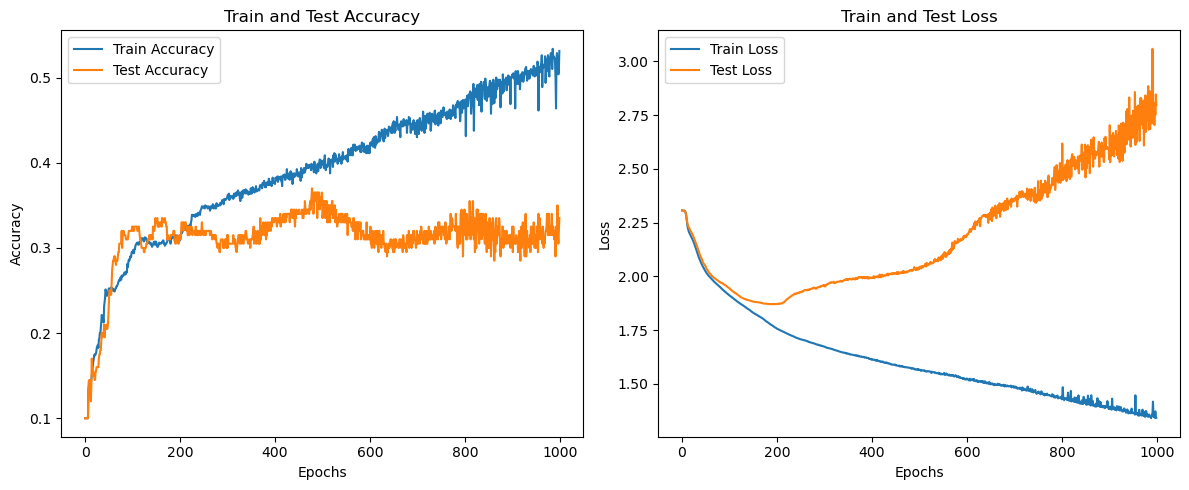

In [356]:
# Plot accuracies
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Plot losses
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()

plt.tight_layout()
plt.show()